# Spam Mail detection Machine Learning 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# data preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
# Model Building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
# Model saving
import pickle

### Explorative Data Analysis

EDA is performed to understand better the data and it's characteristics or patterns. We check for some missing values, check the distribution of the data to see if it is balanced, check the average length of the mails and explore the relationsship of the features with a heatmap. 

In [10]:
# Data import
data = pd.read_csv("train_data.csv",encoding='latin1')
data.sample(5)

,Mail Text,Label
558,Transport Inquiry: 1200kg of Home Appliances f...,not spam
1907,Need transport for 800kg of perishables from B...,not spam
598,Transport Request: 200kg of Artistic Supplies ...,not spam
1602,Act Now! Ship 600 kg of textiles from Chicago ...,spam
1197,Transport Needed: 2 tons of electronics from C...,not spam


In [11]:
# checking for missing values
data.isnull().sum()

Mail Text    0
Label        0
dtype: int64

In [12]:
# checking if outcome variable is binary
data.nunique()

Mail Text    2639
Label           2
dtype: int64

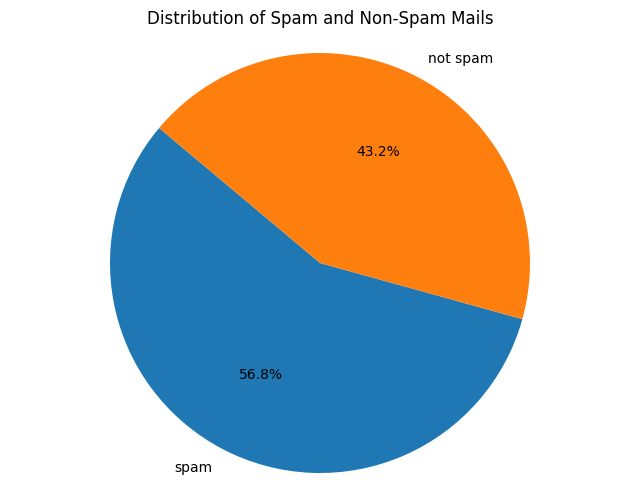

In [13]:
# Plotting
plt.figure(figsize=(8, 6))
plt.pie(data['Label'].value_counts(), labels=data['Label'].value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Spam and Non-Spam Mails')
plt.axis('equal') 
plt.show()

##### Average Length of mails

Average Length of Spam Emails: 117.04026402640264
Average Length of Not Spam Emails: 140.03645833333334


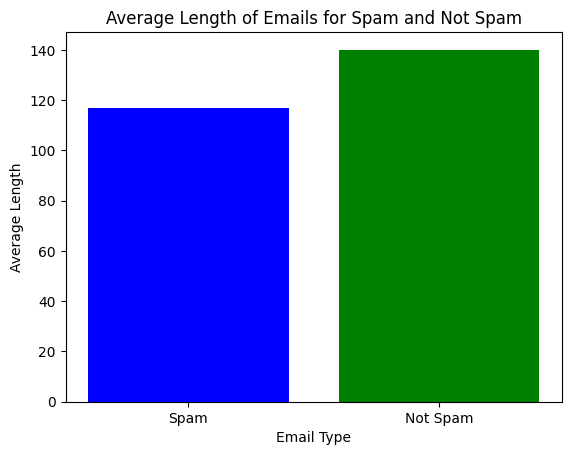

In [14]:
data['Length'] = data['Mail Text'].apply(len)
data['num_words'] = data['Mail Text'].apply(word_tokenize).apply(len)
data['num_sentence'] = data['Mail Text'].apply(sent_tokenize).apply(len)
data.head(2)
avg_length_spam = data[data['Label'] == 'spam']['Length'].mean()
avg_length_ham = data[data['Label'] == 'not spam']['Length'].mean()

#plotting
print("Average Length of Spam Emails:", avg_length_spam)
print("Average Length of Not Spam Emails:", avg_length_ham)
plt.bar(['Spam', 'Not Spam'], [avg_length_spam, avg_length_ham], color=['Blue', 'green'])
plt.title('Average Length of Emails for Spam and Not Spam')
plt.xlabel('Email Type')
plt.ylabel('Average Length')
plt.show()

##### Relationship between Length and Label

Correlation coefficient between email length and spam classification: -0.3392106652991198


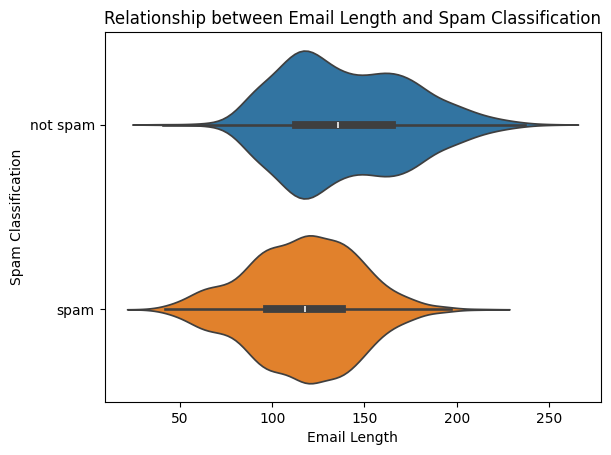

In [15]:
correlation = data['Length'].corr((data['Label'] == 'spam').astype(int))
print("Correlation coefficient between email length and spam classification:", correlation)


sns.violinplot(data=data, x='Length', y='Label', hue='Label')
plt.xlabel('Email Length')
plt.ylabel('Spam Classification')
plt.title('Relationship between Email Length and Spam Classification')
plt.show()

##### Relationship between features

The Relationship between Features are                  Length  num_words  num_sentence
Length        1.000000   0.941088      0.281171
num_words     0.941088   1.000000      0.360502
num_sentence  0.281171   0.360502      1.000000


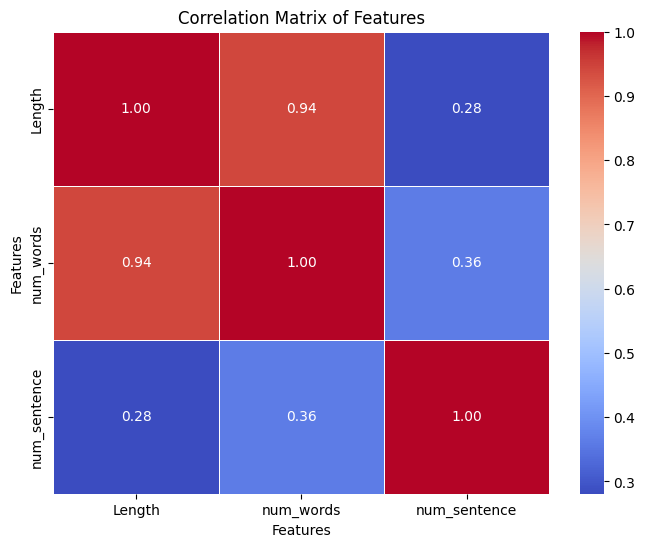

In [16]:
correlation_matrix = data[['Length', 'num_words', 'num_sentence']].corr()
print("The Relationship between Features are ",correlation_matrix )
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

### Preprocessing

To prepare data for ML it has to be preprocessed. For this, the text of the mails get lowercased, tokenized (fragmented into single words), special characters and stopwords (common words which don't contribute to the meaning of a sentence) are removed and at stemming the single words are converted into its root (eg. teacher, teaching, teached -> teach)

In [17]:
# Lowercasing
data['transform_text'] = data['Mail Text'].str.lower()

# Tokenization
data['transform_text'] = data['transform_text'].apply(word_tokenize)

# Removing special characters
data['transform_text'] = data['transform_text'].apply(lambda x: [re.sub(r'[^a-zA-Z0-9\s]', '', word) for word in x])

# Removing stop words and punctuation
stop_words = set(stopwords.words('english'))
data['transform_text'] = data['transform_text'].apply(lambda x: [word for word in x if word not in stop_words and word not in string.punctuation])

# Stemming
ps = PorterStemmer()
data['transform_text'] = data['transform_text'].apply(lambda x: [ps.stem(word) for word in x])

# Convert the preprocessed text back to string
data['transform_text'] = data['transform_text'].apply(lambda x: ' '.join(x))

# Display the preprocessed data
print(data[['Mail Text', 'transform_text']].head())

                                           Mail Text  \
0  Request for transport of 500 kg of electronics...   
1  Urgent: Need to ship 1000 kg of textiles from ...   
2  Transport request for 300 kg of perishable goo...   
3  Act Fast! Ship 200 kg of mysterious cargo for ...   
4  I need to arrange transport for 750 kg of mach...   

                                      transform_text  
0  request transport 500 kg electron berlin amste...  
1  urgent need ship 1000 kg textil guangzhou lo a...  
2  transport request 300 kg perish good madrid pa...  
3  act fast ship 200 kg mysteri cargo 100 limit t...  
4  need arrang transport 750 kg machineri detroit...  


##### Wordcloud for Spam mails

Wordclouds create clouds of the words which occur most frequently in mails or spam mails. This helps in getting a better feeling what the respective mails commonly look like.

Top 10 Most Common Words in Spam Emails:
ship: 918 occurrences
payment: 866 occurrences
subject: 730 occurrences
transport: 715 occurrences
nbodi: 674 occurrences
offer: 627 occurrences
act: 384 occurrences
limit: 380 occurrences
pay: 363 occurrences
cargo: 322 occurrences


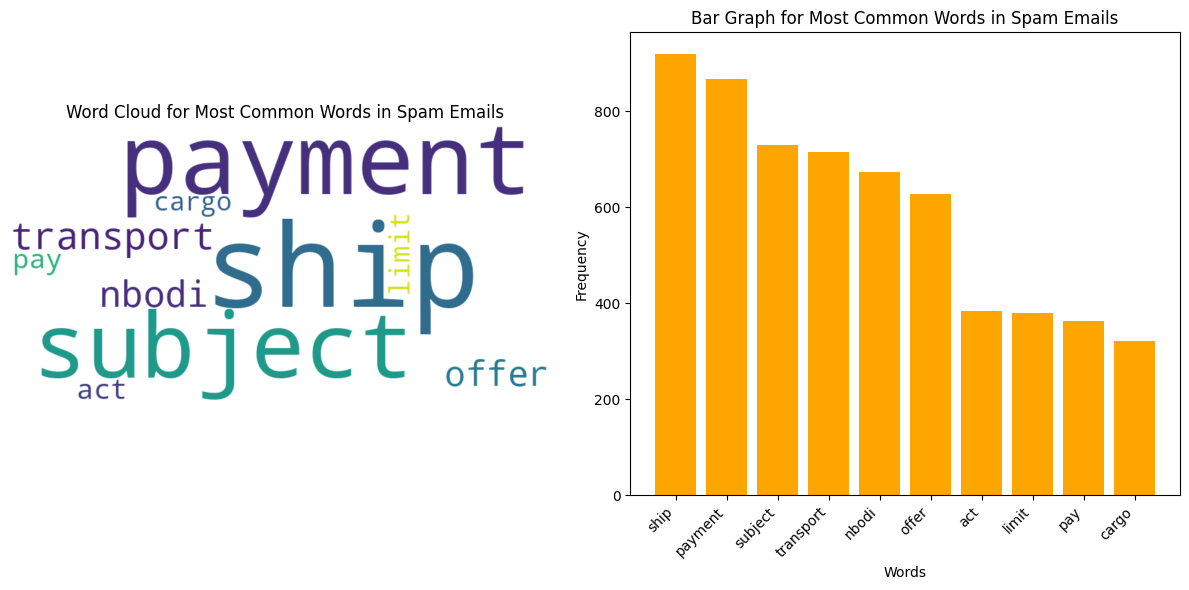

In [18]:
spam_emails = data[data['Label'] == 'spam']['transform_text']
# Tokenize the text in spam emails
spam_words = ' '.join(spam_emails).split()
# Count occurrences of each word
word_counts = Counter(spam_words)
# Find the most common words
most_common_words = word_counts.most_common(10)
print("Top 10 Most Common Words in Spam Emails:")
for word, count in most_common_words:
    print(f"{word}: {count} occurrences")
    # Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))
# Plot Word Cloud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in Spam Emails')
plt.axis('off')
# Plot Bar Graph
plt.subplot(1, 2, 2)
words, counts = zip(*most_common_words)
plt.bar(words, counts, color='orange')
plt.title('Bar Graph for Most Common Words in Spam Emails')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### Wordcloud for Not Spam mails

Top 10 Most Common Words in Spam Emails:
transport: 1061 occurrences
payment: 1024 occurrences
request: 637 occurrences
need: 480 occurrences
deliveri: 433 occurrences
subject: 403 occurrences
cost: 382 occurrences
term: 351 occurrences
price: 343 occurrences
pleas: 339 occurrences


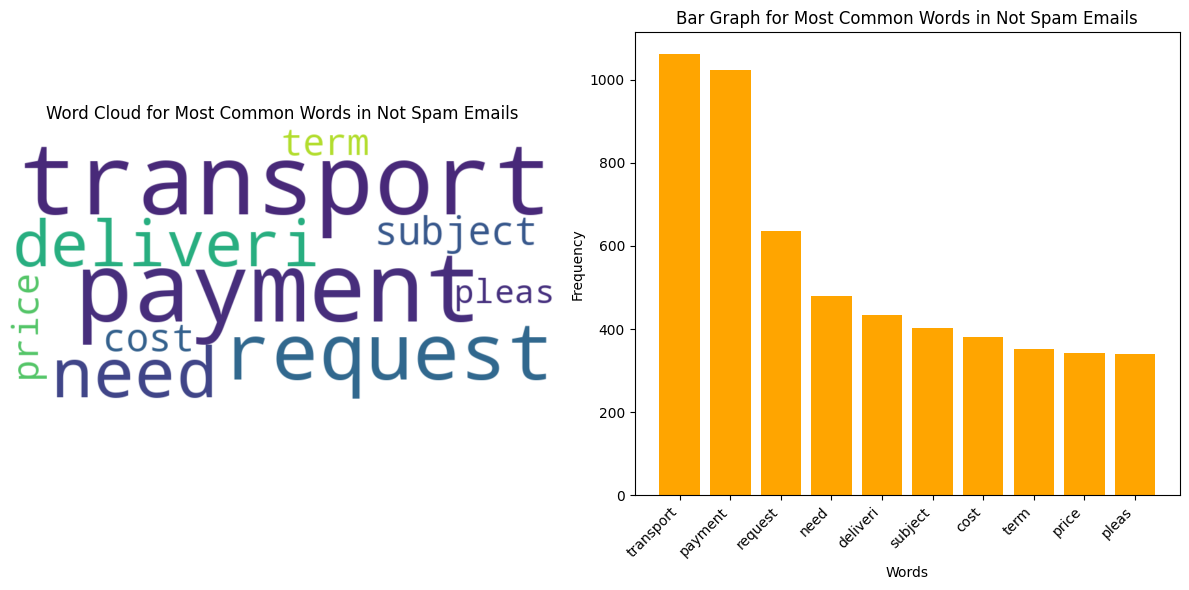

In [19]:
spam_emails = data[data['Label'] == 'not spam']['transform_text']
# Tokenize the text in spam emails
spam_words = ' '.join(spam_emails).split()
# Count occurrences of each word
word_counts = Counter(spam_words)
# Find the most common words
most_common_words = word_counts.most_common(10)
print("Top 10 Most Common Words in Spam Emails:")
for word, count in most_common_words:
    print(f"{word}: {count} occurrences")
    # Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))
# Plot Word Cloud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in Not Spam Emails')
plt.axis('off')
# Plot Bar Graph
plt.subplot(1, 2, 2)
words, counts = zip(*most_common_words)
plt.bar(words, counts, color='orange')
plt.title('Bar Graph for Most Common Words in Not Spam Emails')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Machine Learning

For building a ML model three different model are built and evaluated on the processed data: Support Vector Machine, Random Forest Classifier and Naive Bayes Classifier. The model with the best evaluation metrics was choosen -> Random Forest classifier.

In [20]:
encoder = LabelEncoder()
data['Label'] = encoder.fit_transform(data['Label'])
data.sample(2)

#data spliting and vectorization
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(data['Mail Text']).toarray()
y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Model building

In [21]:
# Support Vector Machine
svc_classifier = SVC()
svc_classifier.fit(X_train, y_train)
y_pred_svc = svc_classifier.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"SVM Accuracy: {accuracy_svc}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_svc))
print("Precision Score: ",precision_score(y_test,y_pred_svc))

SVM Accuracy: 0.9925093632958801
confusion Matrix : [[225   3]
 [  1 305]]
Precision Score:  0.9902597402597403


In [22]:
# Random Forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_rf))
print("Precision Score: ",precision_score(y_test,y_pred_rf))

Random Forest Accuracy: 0.9906367041198502
confusion Matrix : [[225   3]
 [  2 304]]
Precision Score:  0.990228013029316


In [23]:
# Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
y_pred_nb = nb_classifier.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy_nb}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_nb))
print("Precision Score: ",precision_score(y_test,y_pred_nb))

Naive Bayes Accuracy: 0.9868913857677902
confusion Matrix : [[225   3]
 [  4 302]]
Precision Score:  0.9901639344262295


##### Compare models

All three models can be compared visually on both metrics on these two graphs.

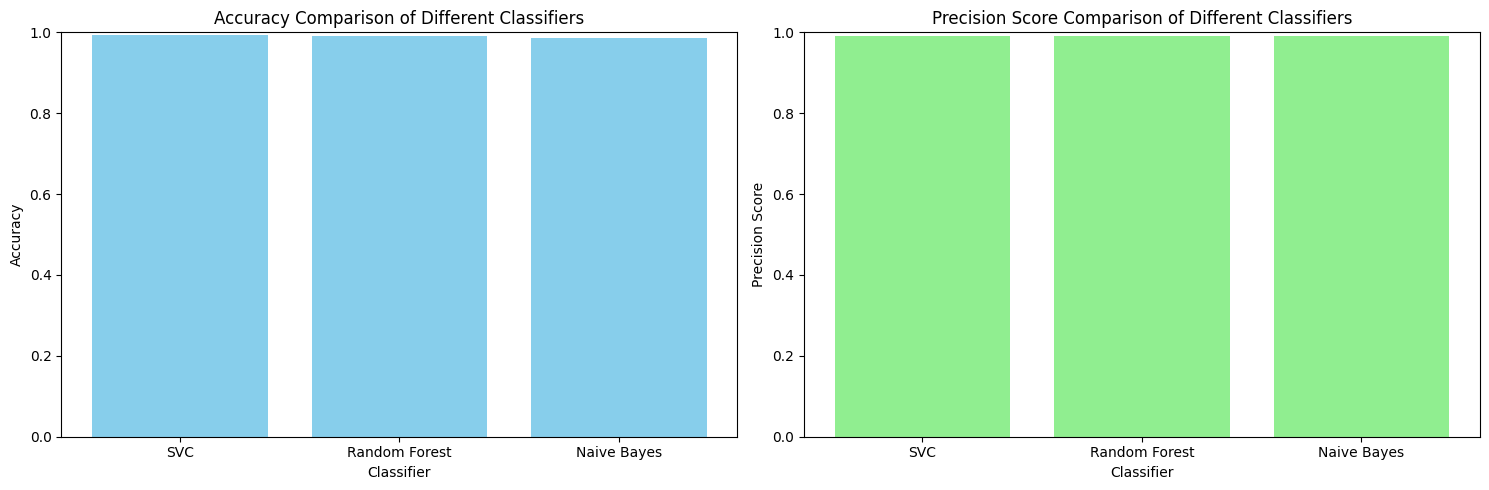

In [24]:
# Calculate precision scores for each classifier
precision_svc = precision_score(y_test, y_pred_svc)
precision_rf = precision_score(y_test, y_pred_rf)
precision_nb = precision_score(y_test, y_pred_nb)

# Create lists to store accuracies and precision scores
classifiers = ['SVC', 'Random Forest', 'Naive Bayes']
accuracies = [accuracy_svc, accuracy_rf, accuracy_nb]
precision_scores = [precision_svc, precision_rf, precision_nb]

# Plot bar graph for accuracies and precision scores side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot bar graph for accuracies
axes[0].bar(classifiers, accuracies, color='skyblue')
axes[0].set_xlabel('Classifier')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison of Different Classifiers')
axes[0].set_ylim(0, 1)

# Plot bar graph for precision scores
axes[1].bar(classifiers, precision_scores, color='lightgreen')
axes[1].set_xlabel('Classifier')
axes[1].set_ylabel('Precision Score')
axes[1].set_title('Precision Score Comparison of Different Classifiers')
axes[1].set_ylim(0, 1)
plt.tight_layout()
plt.show()

##### Save model as pickle 

He the model is permanently saved on the system and can be retrieved any time.

In [25]:
# model saving
with open('rf_model.pkl', 'wb') as file:
    pickle.dump(rf_classifier, file)

In [26]:
# Loading model
with open('rf_model.pkl', 'rb') as file:
    rf_classifier_loaded = pickle.load(file)

##### Model prediction

After retrieving the stored model it is used to run to classify some new data.

In [27]:
new_emails = [
    "Dear Sir/Madam, We need a quote for transporting 10 pallets from Berlin to Amsterdam. The weight is 5,000 kg. Regards, John Doe, TransLogistics Ltd.",
    "Hello, I need an urgent shipment with an immediate payment of €50,000. Provide your details for deposit. No other information needed now. Regards, Unknown Sender Co.",
    "Dear Team, We're looking to ship 12 containers from Munich to Madrid. Please provide pricing and delivery time estimates. Regards, Anna Müller, EuroTrans ",
    "Hi, I need a truck for a valuable cargo. Offering €20,000 for transport. Please provide your bank details for prepayment. Regards, Global Freight Movers."
]

# Convert new data into numerical vectors using the trained tfidf_vectorizer
new_X = tfidf.transform(new_emails)
new_X_dense = new_X.toarray()

# Use the trained SVM model to make predictions
rf_predictions = rf_classifier_loaded.predict(new_X_dense)

# Print the predictions
for email, prediction in zip(new_emails, rf_predictions):
    if prediction == 1:
        print(f"'{email}' is predicted as spam.")
    else:
        print(f"'{email}' is predicted as not spam.")

'Dear Sir/Madam, We need a quote for transporting 10 pallets from Berlin to Amsterdam. The weight is 5,000 kg. Regards, John Doe, TransLogistics Ltd.' is predicted as not spam.
'Hello, I need an urgent shipment with an immediate payment of €50,000. Provide your details for deposit. No other information needed now. Regards, Unknown Sender Co.' is predicted as spam.
'Dear Team, We're looking to ship 12 containers from Munich to Madrid. Please provide pricing and delivery time estimates. Regards, Anna Müller, EuroTrans ' is predicted as not spam.
'Hi, I need a truck for a valuable cargo. Offering €20,000 for transport. Please provide your bank details for prepayment. Regards, Global Freight Movers.' is predicted as spam.


In [28]:
# Here some new mails can be entered manually by an opening input field

def predict_email(email):
    # Convert email into numerical vector using the trained TF-IDF vectorizer
    email_vector = tfidf.transform([email])
    
    # Convert sparse matrix to dense array
    email_vector_dense = email_vector.toarray()
    
    # Use the trained SVM model to make predictions
    prediction = rf_classifier_loaded.predict(email_vector_dense)
    
    # Print the prediction
    if prediction[0] == 1:
        print("The email is predicted as spam.")
    else:
        print("The email is predicted as not spam.")

# Get user input for email
user_email = input("Enter the email text: ")

# Predict whether the input email is spam or ham
predict_email(user_email)

The email is predicted as spam.
